<a href="https://colab.research.google.com/github/deepenmi/pyTorchPractice/blob/master/TransferLearning_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 25.64 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls

ants_and_bees  sample_data


In [5]:
!ls ants_and_bees/


train  val


In [8]:
!ls ants_and_bees/train/


ants  bees


In [0]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                                    ])
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                                ])
training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)

In [22]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [0]:
classes = ('ant', 'bee')

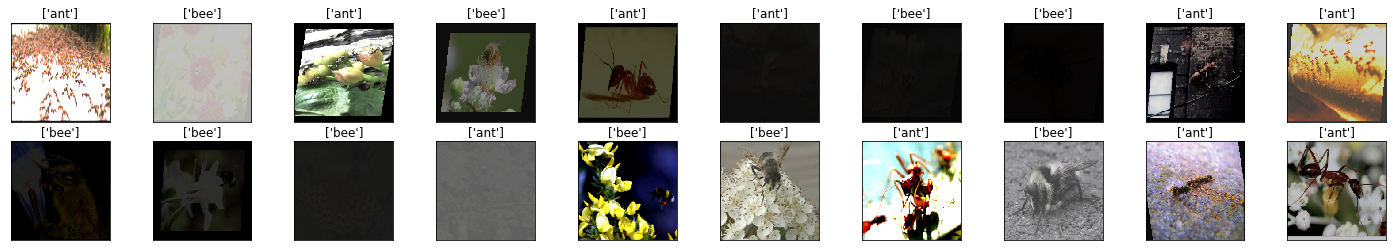

In [25]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([classes[labels[idx].item()]])

In [0]:
model = models.alexnet(pretrained=True)

In [27]:

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
for param in model.features.parameters():
  param.requires_grad = False

In [29]:
import torch
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer 
model.to(device)

#print(model)
print(model.classifier[6].out_features)

2


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [31]:
epochs = 10
running_loss_history = []
running_corrects_history = []

val_running_loss_history=[]
val_running_corrects_history=[]

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  print(e)
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
    running_loss+=loss.item()
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_corrects += torch.sum(val_preds == val_labels.data)
        val_running_loss+=val_loss.item()

    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float() / len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('training loss: {:.4f}, accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item())) 
    print('Validation loss: {:.4f}, accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

0
training loss: 0.1062, accuracy: 0.5984
Validation loss: 0.0191, accuracy: 0.8366
1
training loss: 0.0479, accuracy: 0.6311
Validation loss: 0.0234, accuracy: 0.8170
2
training loss: 0.0299, accuracy: 0.6885
Validation loss: 0.0228, accuracy: 0.8235
3
training loss: 0.0259, accuracy: 0.7746
Validation loss: 0.0252, accuracy: 0.8235
4
training loss: 0.0267, accuracy: 0.7172
Validation loss: 0.0229, accuracy: 0.7908
5
training loss: 0.0237, accuracy: 0.7910
Validation loss: 0.0300, accuracy: 0.8170
6
training loss: 0.0252, accuracy: 0.7541
Validation loss: 0.0207, accuracy: 0.8693
7
training loss: 0.0233, accuracy: 0.7705
Validation loss: 0.0302, accuracy: 0.8497
8
training loss: 0.0250, accuracy: 0.7869
Validation loss: 0.0217, accuracy: 0.8497
9
training loss: 0.0197, accuracy: 0.8033
Validation loss: 0.0247, accuracy: 0.8431


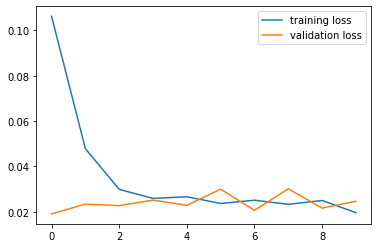

In [32]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history,label='validation loss')
plt.legend()

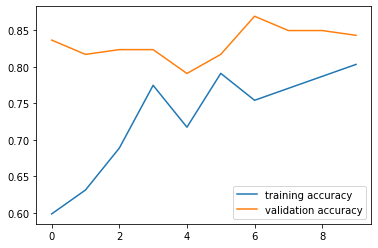

In [33]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history,label='validation accuracy')
plt.legend()

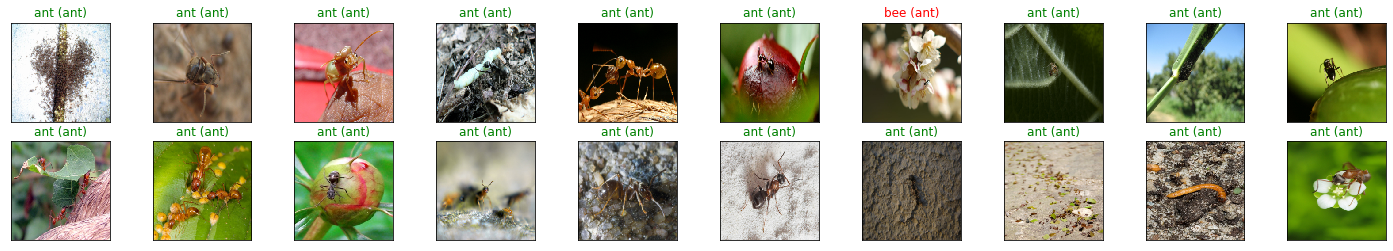

In [34]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
#images_ = images.view(images.shape[0], -1)
outputs = model(images)
_, preds = torch.max(outputs,1)

fig = plt.figure(figsize=(25, 4))
ax.set_title([classes[labels[idx].item()]])
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))


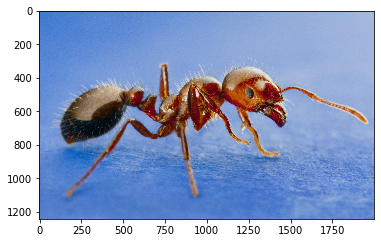

In [39]:
import PIL.ImageOps
import requests
from PIL import Image

url='https://streamline.imgix.net/1cca8323-3187-498c-8b25-aaba2dd01e48/2c3d7f70-110a-48c7-a88c-30112c774481/rifa_a.jpg?ixlib=rb-1.1.0&w=2000&h=2000&fit=max&or=0&s=db9eba131146d6e3c95ef82f1aab6f70'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

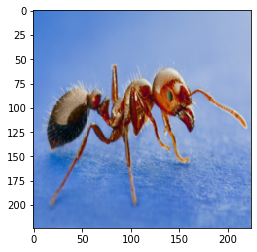

In [40]:
#img = PIL.ImageOps.invert(img)
#img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [41]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ant


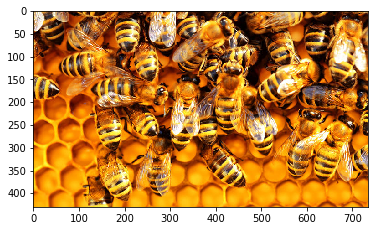

In [42]:
url='https://www.helsinki.fi/sites/default/files/styles/12_7_medium/public/thumbnails/image/his_primebee_1184.jpg?itok=pKlg0i4c'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

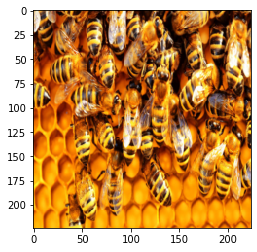

In [43]:
img = transform(img)
plt.imshow(im_convert(img))

In [44]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee
